In [7]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import os
import time
import math

np.random.seed(100)
torch.manual_seed(100)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [8]:
datadir = "../../dataset/MNIST"
batch_size = 5
epochs = 20


In [9]:
traindataloader = DataLoader(
    torchvision.datasets.MNIST(datadir, train=True, download=False,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                               ])),batch_size=batch_size, shuffle=True)

testdataloader = DataLoader(
    torchvision.datasets.MNIST(datadir, train=False, download=False,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                               ])),batch_size=batch_size, shuffle=True)



In [10]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20) # 期望 mean
        self.fc22 = nn.Linear(400, 20) # 方差 log var
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    # 如果按高斯分布去取， 那就变成了一个随机取值的函数，不能方向传播。 这里改了一下就变成了一个系数随机， mean和var是变量的函数， 只要系数随机确定了， 那这就是一个一元函数
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

### 信息量
I = log(1/p)
### 熵, 一个分布的信息量期望
H = E(p*Ip)
### 交叉熵, q 是我们估计出来的分布， p 是实际发生的概率。 这个函数的下界是 熵， 如果预测的很准， 那就=熵
H = E(p*Iq)
### KL散度 比较两个概率分布的差异
KLD = 交叉熵 - 熵

https://www.bilibili.com/video/BV1JY411q72n

### 变分
https://www.bilibili.com/video/BV1sM4y1W7jx

logpx = C = ELBO + KLD 

如果只用交叉熵， 那么这就是个离散的分类， 从原值返回原值一定是个过拟合的东西  
如果输入一个三角一个方块一个圆形， 期望得到一个平滑过度的图像， 而离散的预测会导致中间的区域都是完全随机的  
所以需要将隐空间变成一个连续的分布

KL散度如果越小， 代表两个分布越相似， 所以这里想要用一个 分布 去尽量拟合 p(z|x) , p(z|x)是已有样本后的隐空间的分布， 也就是让假设的隐空间尽量拟合当前的样本
KL散度不好求， 因为图像长成什么样子是无限可能的， 所以改用最大化 ELBO 来实现 KL 的最小化  
KL=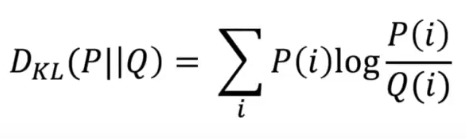  
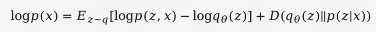  
ELBO = 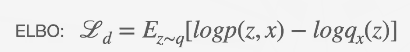  

假设 p(x,z)  p(z) 为高斯分布， 带参数  

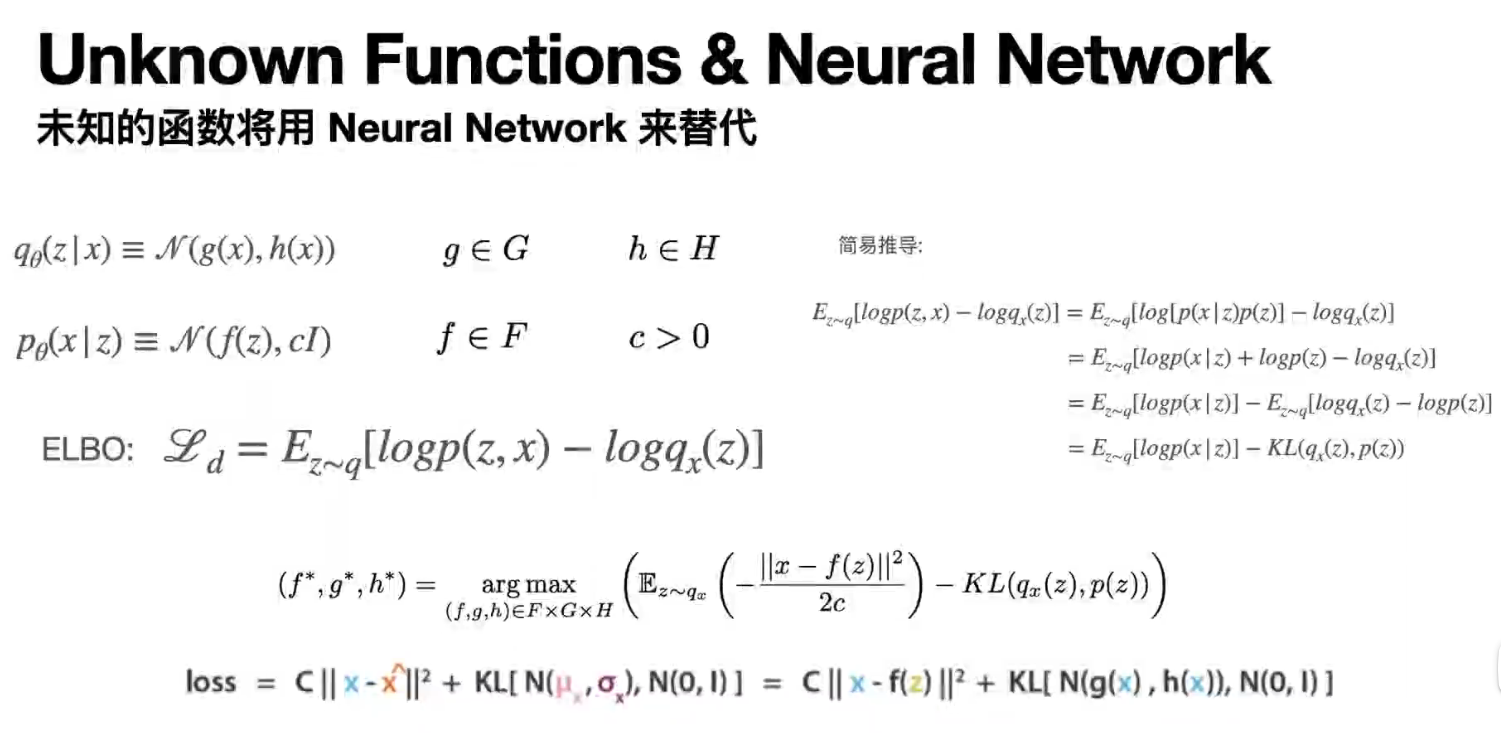  

其中 g(x) h(x) 是encoder生成mean和var的函数  
f(x) z的分布  

In [11]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + KLD


In [12]:

model = VAE().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(traindataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(traindataloader.dataset),
                100. * batch_idx / len(traindataloader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(traindataloader.dataset)))


In [13]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(testdataloader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/vae_reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(testdataloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

for epoch in range(epochs):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                    'results/vae_sample_' + str(epoch) + '.png')

Train Epoch: 0 [0/60000 (0%)]	Loss: 545.895605
Train Epoch: 0 [250/60000 (0%)]	Loss: 188.543640
Train Epoch: 0 [500/60000 (1%)]	Loss: 206.240088
Train Epoch: 0 [750/60000 (1%)]	Loss: 207.463794
Train Epoch: 0 [1000/60000 (2%)]	Loss: 174.007678
Train Epoch: 0 [1250/60000 (2%)]	Loss: 155.848865
Train Epoch: 0 [1500/60000 (2%)]	Loss: 196.607983
Train Epoch: 0 [1750/60000 (3%)]	Loss: 170.157178
Train Epoch: 0 [2000/60000 (3%)]	Loss: 136.044934
Train Epoch: 0 [2250/60000 (4%)]	Loss: 190.533618
Train Epoch: 0 [2500/60000 (4%)]	Loss: 141.127441
Train Epoch: 0 [2750/60000 (5%)]	Loss: 165.180762
Train Epoch: 0 [3000/60000 (5%)]	Loss: 122.413306
Train Epoch: 0 [3250/60000 (5%)]	Loss: 173.868237
Train Epoch: 0 [3500/60000 (6%)]	Loss: 167.577722
Train Epoch: 0 [3750/60000 (6%)]	Loss: 136.062231
Train Epoch: 0 [4000/60000 (7%)]	Loss: 143.714526
Train Epoch: 0 [4250/60000 (7%)]	Loss: 144.499194
Train Epoch: 0 [4500/60000 (8%)]	Loss: 135.744861
Train Epoch: 0 [4750/60000 (8%)]	Loss: 151.395215
Train 